In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsfresh.utilities.dataframe_functions import impute

In [93]:
base_path = "..\\mimic-iii-clinical-database-demo-1.4"
base_path = "S:\\Work\\mimic-iii-clinical-database-1.4"

## identify diagnosis codes related to liver problems
diagnosis_labels = pd.read_csv(f'{base_path}\\D_ICD_DIAGNOSES.csv.gz')
diagnosis_labels


,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."
...,...,...,...,...
14562,14432,V7399,Scrn unspcf viral dis,Special screening examination for unspecified ...
14563,14433,V740,Screening for cholera,Screening examination for cholera
14564,14434,V741,Screening-pulmonary TB,Screening examination for pulmonary tuberculosis
14565,14435,V742,Screening for leprosy,Screening examination for leprosy (Hansen's di...


In [96]:
base_path = "..\\mimic-iii-clinical-database-demo-1.4"
base_path = "S:\\Work\\mimic-iii-clinical-database-1.4"

## identify diagnosis codes related to liver problems
diagnosis_labels = pd.read_csv(f'{base_path}\\D_ICD_DIAGNOSES.csv.gz')[['ICD9_CODE', 'LONG_TITLE']]
diagnosis_labels.columns = diagnosis_labels.columns.str.lower()
diagnosis_labels.rename(columns={'icd9_code': 'diag_code'}, inplace=True)

# Filter out codes not related to liver problems including liver donor, liver preparaton
liver_diag_labels = diagnosis_labels[
    diagnosis_labels['long_title'].str.contains(' liver', case=False) &
    ~diagnosis_labels['long_title'].str.lower().str.startswith('liver preparation') &
    ~diagnosis_labels['long_title'].isin(['Liver donors'])
]

# Display the selected liver diag codes and title
print(liver_diag_labels)

## Load diagnosis with liver disease, and get all associated admission ids
diagnoses = pd.read_csv(f'{base_path}\\DIAGNOSES_ICD.csv.gz')[['HADM_ID', 'ICD9_CODE']]
diagnoses.columns = diagnoses.columns.str.lower()
diagnoses.rename(columns={'icd9_code': 'diag_code'}, inplace=True)
liver_diagnoses_admids = pd.merge(diagnoses, liver_diag_labels['diag_code'], on='diag_code', how='inner')['hadm_id'].drop_duplicates()

      diag_code                                         long_title
168        0063                               Amebic liver abscess
390        0953                                  Syphilis of liver
1094       1220         Echinococcus granulosus infection of liver
1099       1225     Echinococcus multilocularis infection of liver
1102       1228              Echinococcosis, unspecified, of liver
...         ...                                                ...
14133     86403  Injury to liver without mention of open wound ...
14134     86404  Injury to liver without mention of open wound ...
14135     86405  Injury to liver without mention of open wound ...
14136     86409  Other injury to liver without mention of open ...
14137     86410  Injury to liver with open wound into cavity, u...

[45 rows x 2 columns]


In [ ]:
## get and filter lab events as features to be trained, display data types to check for data type conversion
lab_labels = pd.read_csv(f'{base_path}\\D_LABITEMS.csv.gz')[['ITEMID', 'LABEL']]
lab_labels.columns = lab_labels.columns.str.lower()
lab_labels.info()
liver_lab_itemids = [50861, 50878, 51241, 50863, 50883, 50884, 50885, 51012, 51028, 51049, 51464, 51465, 50835, 
                     50862, 51011, 51019, 51025, 51046, 51069, 51070, 51555, 51237, 50906, 50904, 51000, 50809]
lab_labels = lab_labels[lab_labels.itemid.isin(liver_lab_itemids)]
lab_labels.info()
print(lab_labels)

## Load lab events with selected itemids
lab_events = pd.DataFrame()
for chunk in pd.read_csv(f'{base_path}\\LABEVENTS.csv.gz', chunksize=10000):
    chunk.columns = chunk.columns.str.lower()
    filtered_chunk = chunk[chunk.itemid.isin(liver_lab_itemids)][['subject_id', 'hadm_id', 'itemid', 
                                                                  'charttime', 'valuenum', 'valueuom']]
    filtered_chunk.dropna(subset=['subject_id', 'hadm_id', 'itemid', 'valuenum', 'valueuom'], inplace=True)
    lab_events = pd.concat([lab_events, filtered_chunk])
lab_events.valueuom = lab_events.valueuom.str.lower()

lab_events.info()
print(lab_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   itemid  753 non-null    int64 
 1   label   753 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, 118 to 752
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   itemid  26 non-null     int64 
 1   label   26 non-null     object
dtypes: int64(1), object(1)
memory usage: 624.0+ bytes
     itemid                            label
118   51464                        Bilirubin
119   51465               Bilirubin Crystals
136   50809                          Glucose
162   50835                 Albumin, Ascites
188   50861   Alanine Aminotransferase (ALT)
189   50862                          Albumin
190   50863             Alkaline Phosphatase
205   50878  Asparate Aminotransferase (AS

In [101]:
## count number of events for each labitem
lab_events_cnt = lab_events.groupby(['itemid', 'valueuom']).size()
lab_events_cnt = lab_events_cnt.reset_index()
lab_events_cnt['label'] = lab_events_cnt.itemid.map(lab_labels.set_index('itemid').label)
lab_events_cnt = lab_events_cnt.reset_index().sort_values('label')
lab_events_cnt = lab_events_cnt.rename(columns={0: 'num_events'})

lab_events_cnt.info()
pd.set_option('display.max_rows', 50)
print(lab_events_cnt)

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 12 to 11
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       22 non-null     int64 
 1   itemid      22 non-null     int64 
 2   valueuom    22 non-null     object
 3   num_events  22 non-null     int64 
 4   label       22 non-null     object
dtypes: int64(3), object(2)
memory usage: 1.0+ KB
    index  itemid valueuom  num_events                            label
12     12   51011    mg/dl          20                        <Albumin>
2       2   50861     iu/l      148453   Alanine Aminotransferase (ALT)
3       3   50862     g/dl       98968                          Albumin
1       1   50835     g/dl         632                 Albumin, Ascites
15     15   51025     g/dl         359              Albumin, Body Fluid
14     14   51019     g/dl           1             Albumin, Joint Fluid
17     17   51046     g/dl         744                 Albumin, Pleu

In [102]:
## Load admissions
admissions = pd.read_csv(f'{base_path}\\ADMISSIONS.csv.gz')[['SUBJECT_ID', 'HADM_ID', 'ETHNICITY', 'ADMITTIME']]
admissions.columns = admissions.columns.str.lower()
admissions.info()
admissions.dropna(subset=['subject_id', 'hadm_id'], inplace=True)
admissions.ethnicity = admissions.ethnicity.replace('', np.nan)
admissions.ethnicity = admissions.ethnicity.fillna('UNKNOWN/NOT SPECIFIED')

## add patient data
patients = pd.read_csv(f'{base_path}\\PATIENTS.csv.gz')[['SUBJECT_ID', 'GENDER', 'DOB']]
patients.columns = patients.columns.str.lower()
patients.dropna(subset=['subject_id', 'gender', 'dob'])
patients.info()
patients_admis = pd.merge(patients, admissions, on='subject_id', how='inner')
patients_admis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  58976 non-null  int64 
 1   hadm_id     58976 non-null  int64 
 2   ethnicity   58976 non-null  object
 3   admittime   58976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  46520 non-null  int64 
 1   gender      46520 non-null  object
 2   dob         46520 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  58976 non-null  int64 
 1   gender     

In [103]:
## convert data to datetime/numbers, print first couple rows as a sample, to look for text to numeric conversion opportunities
patients_admis.dob = pd.to_datetime(patients_admis.dob, errors='coerce')
patients_admis.admittime = pd.to_datetime(patients_admis.admittime, errors='coerce')

## compute age of patient at the time of admission, removing age when it's greater than 120 or negative as values are invalid
def compute_age(current_date, date_of_birth):
    age = (current_date.date() - date_of_birth.date()).days/365.0
    if age > 120 or age < 0: 
        return np.nan
    return age
patients_admis['age'] = patients_admis.apply(lambda row: compute_age(row.admittime, row.dob), axis=1)
patients_admis.drop(['dob', 'admittime'], axis=1)
print(patients_admis[0:5])

## mark liver_disease as 1 if admission id exists in liver_diagnoses_admids, 0 otherwise
patients_admis_label = pd.merge(patients_admis, liver_diagnoses_admids, on=['hadm_id'], how='left', indicator=True)
patients_admis_label['liver_disease'] = patients_admis_label['_merge'].apply(lambda x:1 if x == 'both' else 0)
patients_admis_label.drop(columns=['_merge'], inplace=True)

# prepare lab events matching data type in other dataframes
lab_labels.info()
print(lab_labels[0:5])
lab_events.charttime = pd.to_datetime(lab_events.charttime)
lab_events['hadm_id'] = pd.to_numeric(lab_events['hadm_id'], errors='coerce')
lab_events.dropna(subset=['hadm_id'], inplace=True)
lab_events.hadm_id = lab_events.hadm_id.astype('int64')
print(lab_events[0:5])
lab_events.info()

   subject_id gender        dob  hadm_id               ethnicity  \
0         249      F 2075-03-13   116935                   WHITE   
1         249      F 2075-03-13   149546                   WHITE   
2         249      F 2075-03-13   158975                   WHITE   
3         250      F 2164-12-27   124271  BLACK/AFRICAN AMERICAN   
4         251      M 2090-03-15   117937   UNKNOWN/NOT SPECIFIED   

            admittime        age  
0 2149-12-17 20:41:00  74.813699  
1 2155-02-03 20:16:00  79.947945  
2 2156-04-27 15:33:00  81.178082  
3 2188-11-12 09:22:00  23.893151  
4 2110-07-27 06:46:00  20.378082  
<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, 118 to 752
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   itemid  26 non-null     int64 
 1   label   26 non-null     object
dtypes: int64(1), object(1)
memory usage: 624.0+ bytes
     itemid                           label
118   51464                       Bili

In [104]:
## evaluate text values for conversion consideration
print(patients_admis_label.ethnicity.value_counts())
patients_admis_label.loc[(patients_admis_label.ethnicity == 'UNABLE TO OBTAIN') | 
               (patients_admis_label.ethnicity == 'UNKNOWN/NOT SPECIFIED') | 
               (patients_admis_label.ethnicity == 'PATIENT DECLINED TO ANSWER'), 'ethnicity'] = 'UNKNOWN'
patients_admis_label.loc[patients_admis_label.ethnicity.str.startswith('WHITE'), 'ethnicity'] = 'WHITE'
patients_admis_label.loc[patients_admis_label.ethnicity.str.startswith('ASIAN'), 'ethnicity'] = 'ASIAN'
patients_admis_label.loc[(patients_admis_label.ethnicity == 'MULTI RACE ETHNICITY') | 
               (patients_admis_label.ethnicity == 'MIDDLE EASTERN') | 
               (patients_admis_label.ethnicity == 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER') | 
               (patients_admis_label.ethnicity.str.startswith('AMERICAN INDIAN')) | 
               (patients_admis_label.ethnicity == 'SOUTH AMERICAN'), 'ethnicity'] = 'OTHER'
patients_admis_label.loc[(patients_admis_label.ethnicity.str.startswith('HISPANIC/LATINO')) |
               (patients_admis_label.ethnicity == 'CARIBBEAN ISLAND'), 'ethnicity'] = 'HISPANIC OR LATINO'
patients_admis_label.loc[patients_admis_label.ethnicity.str.startswith('BLACK'), 'ethnicity'] = 'BLACK/AFRICAN'
print(patients_admis_label.ethnicity.value_counts())


ethnicity
WHITE                                                       40996
BLACK/AFRICAN AMERICAN                                       5440
UNKNOWN/NOT SPECIFIED                                        4523
HISPANIC OR LATINO                                           1696
OTHER                                                        1512
ASIAN                                                        1509
UNABLE TO OBTAIN                                              814
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85


In [105]:
## define features including baseline
## fields currently in lab_events: 'subject_id', 'hadm_id', 'itemid', 'charttime', 'valuenum', 'valueuom'
groupby_fields = ['subject_id', 'hadm_id', 'itemid', 'valueuom']
pd.set_option('display.max_rows', 50)
lab_events_grouped = lab_events.groupby(groupby_fields)

## get first lab value of the given admission
idx_first = lab_events_grouped['charttime'].idxmin()
lab_events_first = lab_events.loc[idx_first]
lab_events_first.rename(columns={'valuenum': 'first_valuenum', 'charttime': 'first_charttime'}, inplace=True)

## get last lab value of the given admission
idx_last = lab_events_grouped['charttime'].idxmax()
lab_events_last = lab_events.loc[idx_last]
lab_events_last.rename(columns={'valuenum': 'last_valuenum', 'charttime': 'last_charttime'}, inplace=True)

## merge first, last
first_last = pd.merge(lab_events_first, lab_events_last, on=groupby_fields)
first_last['duration_hours'] = (first_last.last_charttime - first_last.first_charttime).dt.total_seconds()/3600.0
first_last.drop(['last_charttime', 'first_charttime'], inplace=True, axis=1)
labevents_features = pd.merge(lab_events_grouped.agg(
    min_value=('valuenum', 'min'),
    max_value=('valuenum', 'max')), 
    first_last, left_index=True, right_on=['subject_id', 'hadm_id', 'itemid', 'valueuom'])

## compute range, delta between first and last, rate as in delta divided by duration in hours
labevents_features['range_max_min'] = labevents_features.max_value - labevents_features.min_value
labevents_features['delta_last_first'] = labevents_features.last_valuenum - labevents_features.first_valuenum
labevents_features['rate_last_first'] = labevents_features.delta_last_first / labevents_features.duration_hours
labevents_features.fillna({'rate_last_first': 0}, inplace=True)
labevents_features

,min_value,max_value,subject_id,hadm_id,itemid,first_valuenum,valueuom,last_valuenum,duration_hours,range_max_min,delta_last_first,rate_last_first
0,0.3,0.3,2,163353,50883,0.3,mg/dl,0.3,0.000000,0.0,0.0,0.000000
1,9.0,9.0,2,163353,50884,9.0,mg/dl,9.0,0.000000,0.0,0.0,0.000000
2,9.3,9.3,2,163353,50885,9.3,mg/dl,9.3,0.000000,0.0,0.0,0.000000
3,128.0,299.0,3,145834,50809,140.0,mg/dl,128.0,28.216667,171.0,-12.0,-0.425281
4,20.0,25.0,3,145834,50861,25.0,iu/l,20.0,32.016667,5.0,-5.0,-0.156169
...,...,...,...,...,...,...,...,...,...,...,...,...
241045,35.0,35.0,99995,137810,50861,35.0,iu/l,35.0,0.000000,0.0,0.0,0.000000
241046,89.0,89.0,99995,137810,50863,89.0,iu/l,89.0,0.000000,0.0,0.0,0.000000
241047,75.0,75.0,99995,137810,50878,75.0,iu/l,75.0,0.000000,0.0,0.0,0.000000
241048,3.5,3.5,99995,137810,50885,3.5,mg/dl,3.5,0.000000,0.0,0.0,0.000000


In [ ]:
labevents_features_admission = labevents_features.copy()
## combine itemid with its unit of measure
labevents_features_admission['itemid'] = labevents_features['itemid']\
    .astype('str') + '.' + labevents_features['valueuom']
labevents_features_admission.drop(['valueuom'], inplace=True, axis=1)
## for each subject id, admission id, rotate each set of rows into columns, 
# having item id with the features computed for each item id to columns
labevents_features_admission = labevents_features_admission.pivot_table(
    index=['subject_id', 'hadm_id'], columns='itemid', 
    values=['min_value', 'max_value', 'first_valuenum', 'last_valuenum', 
            'range_max_min', 'delta_last_first', 'rate_last_first'])
labevents_features_admission.columns = ['_'.join(col).strip() 
                                        for col in labevents_features_admission.columns.values]
labevents_features_admission.reset_index(inplace=True)
labevents_features_admission

,subject_id,hadm_id,delta_last_first_50809.mg/dl,delta_last_first_50835.g/dl,delta_last_first_50861.iu/l,delta_last_first_50862.g/dl,delta_last_first_50863.iu/l,delta_last_first_50878.iu/l,delta_last_first_50883.mg/dl,delta_last_first_50884.mg/dl,...,rate_last_first_51011.mg/dl,rate_last_first_51012.mg/dl,rate_last_first_51019.g/dl,rate_last_first_51025.g/dl,rate_last_first_51028.mg/dl,rate_last_first_51046.g/dl,rate_last_first_51049.mg/dl,rate_last_first_51069.mg/dl,rate_last_first_51070.mg/g,rate_last_first_51241.score
0,2,163353,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,145834,-12.0,NaN,-5.0,0.0,16.0,-2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,185777,NaN,NaN,-4.0,0.0,-157.0,-5.0,0.0,-0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6,107064,68.0,NaN,-18.0,-0.3,-3.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,118037,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51213,99983,117390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51214,99985,176670,NaN,NaN,-53.0,0.3,87.0,-60.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51215,99992,197084,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51216,99995,137810,15.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## one-hot encode categorical feature in patients
encoded_features = pd.get_dummies(patients_admis_label.drop(['dob'], axis=1), drop_first=True)

## combine features into one dataframe
features_to_impute = pd.merge(labevents_features_admission, encoded_features, 
                              on=['subject_id', 'hadm_id'])\
                                .drop(['subject_id', 'hadm_id', 'admittime'], axis=1)

## replace boolean columns by integer
features_to_impute = features_to_impute.applymap(lambda x: int(x) if isinstance(x, bool) else x)
#pd.set_option('display.max_columns', None)

## impute missing values
features = impute(features_to_impute)
pd.set_option('display.max_rows', None)
print(features.isna().sum())
pd.set_option('display.max_rows', 40)

C:\Users\peter\AppData\Local\Temp\ipykernel_16364\589602253.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features_to_impute = features_to_impute.applymap(lambda x: int(x) if isinstance(x, bool) else x)


delta_last_first_50809.mg/dl    0
delta_last_first_50835.g/dl     0
delta_last_first_50861.iu/l     0
delta_last_first_50862.g/dl     0
delta_last_first_50863.iu/l     0
delta_last_first_50878.iu/l     0
delta_last_first_50883.mg/dl    0
delta_last_first_50884.mg/dl    0
delta_last_first_50885.mg/dl    0
delta_last_first_50904.mg/dl    0
delta_last_first_50906.mg/dl    0
delta_last_first_51000.mg/dl    0
delta_last_first_51011.mg/dl    0
delta_last_first_51012.mg/dl    0
delta_last_first_51019.g/dl     0
delta_last_first_51025.g/dl     0
delta_last_first_51028.mg/dl    0
delta_last_first_51046.g/dl     0
delta_last_first_51049.mg/dl    0
delta_last_first_51069.mg/dl    0
delta_last_first_51070.mg/g     0
delta_last_first_51241.score    0
first_valuenum_50809.mg/dl      0
first_valuenum_50835.g/dl       0
first_valuenum_50861.iu/l       0
first_valuenum_50862.g/dl       0
first_valuenum_50863.iu/l       0
first_valuenum_50878.iu/l       0
first_valuenum_50883.mg/dl      0
first_valuenum

In [108]:
print('Number of positive samples:', (features.liver_disease == 1).sum())
print('Number of negative samples:',  (features.liver_disease == 0).sum())
print('Total samples:', len(features))

Number of positive samples: 5098
Number of negative samples: 46120
Total samples: 51218


In [109]:
# shuffle the samples
features_clean = features.sample(n = len(features), random_state = 12345)
features_clean = features_clean.reset_index(drop = True)

# Save 30% of the data as validation and test data
df_valid_test=features_clean.sample(frac=0.30,random_state=12345)

df_test = df_valid_test.sample(frac = 0.5, random_state = 12345)
df_valid = df_valid_test.drop(df_test.index)

# use the rest of the data as training data
df_train_all=features.drop(df_valid_test.index)

print('Test prevalence(n = %d):'%len(df_test),df_test.liver_disease.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid),df_valid.liver_disease.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.liver_disease.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(features))
assert len(features) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

Test prevalence(n = 7682): 0.09724030200468628
Valid prevalence(n = 7683): 0.1023037875829754
Train all prevalence(n = 35853): 0.09974060748054556
all samples (n = 51218)


In [110]:
# split the training data into positive and negative
rows_pos = df_train_all.liver_disease == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 12345)],axis = 0)

# shuffle the order of training samples
df_train = df_train.sample(n = len(df_train), random_state = 12345).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(df_train), df_train.liver_disease.sum()/ len(df_train))

Train prevalence (n = 7152): 0.5


Separate features from label

In [111]:
x_train = df_train.drop('liver_disease', axis=1)
y_train = df_train.liver_disease
x_valid = df_valid.drop('liver_disease', axis=1)
y_valid = df_valid.liver_disease
x_test = df_test.drop('liver_disease', axis=1)
y_test = df_test.liver_disease

# logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 12345)
clf.fit(x_train, y_train)
model = clf

prdct_train = model.predict_proba(x_train)[:,1]
prdct_valid = model.predict_proba(x_valid)[:,1]
print(y_train[:10].values)
print(prdct_train[:10])

[0 0 1 0 0 0 0 1 1 1]
[0.50813799 0.17832193 0.99997301 0.3965595  0.19805878 0.20416547
 0.18872436 0.27764304 0.99961308 0.96884316]


c:\ProgramData\anaconda3\envs\health\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [112]:

def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

In [113]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def evaluate(prdct_train, y_train, prdct_valid, y_valid, thresh=0.5):
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, prdct_train)
    fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, prdct_valid)

    auc_train = roc_auc_score(y_train, prdct_train)
    auc_valid = roc_auc_score(y_valid, prdct_valid)

    print('Train AUC:%.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)

    print('Train accuracy:%.3f'%calc_accuracy(y_train, prdct_train, thresh))
    print('Valid accuracy:%.3f'%calc_accuracy(y_valid, prdct_valid, thresh))

    print('Train recall:%.3f'%calc_recall(y_train, prdct_train, thresh))
    print('Valid recall:%.3f'%calc_recall(y_valid, prdct_valid, thresh))

    print('Train precision:%.3f'%calc_precision(y_train, prdct_train, thresh))
    print('Valid precision:%.3f'%calc_precision(y_valid, prdct_valid, thresh))

    print('Train specificity:%.3f'%calc_specificity(y_train, prdct_train, thresh))
    print('Valid specificity:%.3f'%calc_specificity(y_valid, prdct_valid, thresh))

    print('Train prevalence:%.3f'%calc_prevalence(y_train))
    print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


    plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
    plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
    plt.plot([0,1],[0,1],'-k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

**Feature importance**

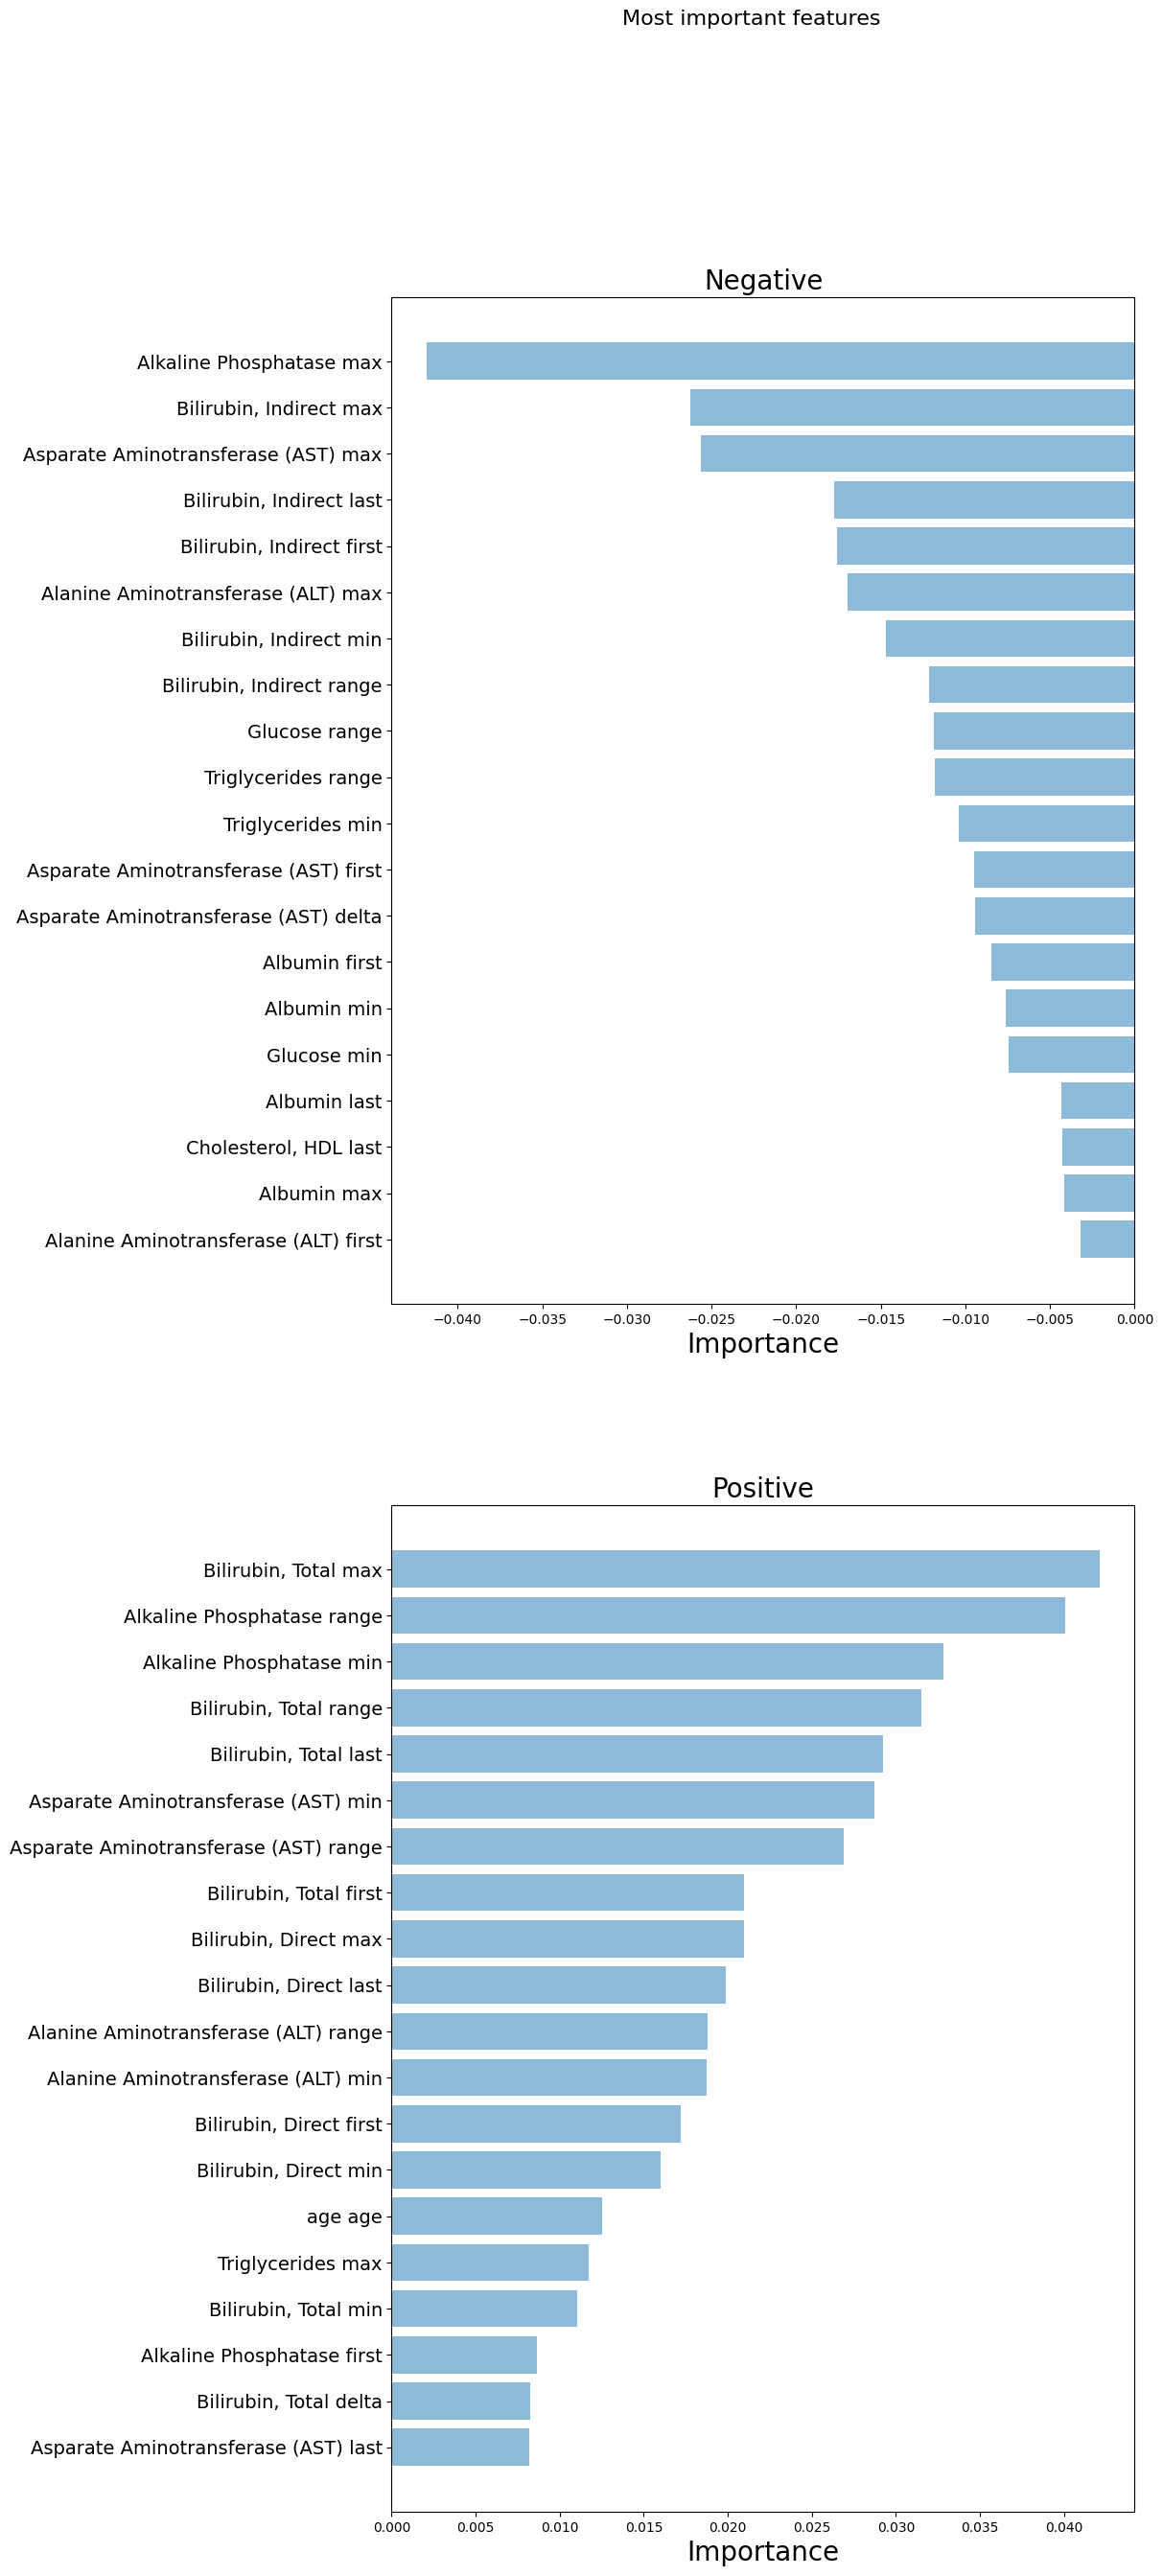

In [114]:
n=20
classes ={}
for class_index in range(model.coef_.shape[0]):
    importances = [(el, x_train.columns[i]) for i,el in enumerate(model.coef_[class_index])]
    sorted_coeff = sorted(importances, key = lambda x : x[0], reverse=True)
    tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
    bottom = sorted_coeff[-n:]
    classes[class_index] = {
        'tops':tops,
        'bottom':bottom
    }

def plot_important(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 30))

    plt.subplot(211)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplot(212)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplots_adjust(wspace=0.8)
    plt.show()

#feature_importance = pd.DataFrame({'feature':x_train.columns, 'importance': classifier_rf.feature_importances_})\
#    .sort_values('importance', ascending=False)
def rename_feature(feature_column_nms):
    feature_nms = pd.DataFrame({'name': feature_column_nms})
    feature_nms['itemid'] = feature_nms['name'].str.split('.').str[0].str.rsplit('_').str[-1]
    feature_nms['feature_type'] = feature_nms['name'].str.split('.').str[0].str.rsplit('_').str[0]
    lab_labels_str = lab_labels.copy()
    lab_labels_str['itemid'] = lab_labels_str['itemid'].astype('str')
    feature_nms = pd.merge(feature_nms, lab_labels_str, on=['itemid'], how='left')
    feature_nms['label'] = feature_nms['label'].fillna(feature_nms['itemid'])
    return feature_nms.label + ' ' + feature_nms.feature_type

top_scores = [a[0] for a in classes[0]['tops']]
top_features = [a[1] for a in classes[0]['tops']]
bottom_scores = [a[0] for a in classes[0]['bottom']]
bottom_features = [a[1] for a in classes[0]['bottom']]

plot_important(top_scores, rename_feature(top_features), bottom_scores, rename_feature(bottom_features), "Most important features")

**Training Selection**

In [115]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

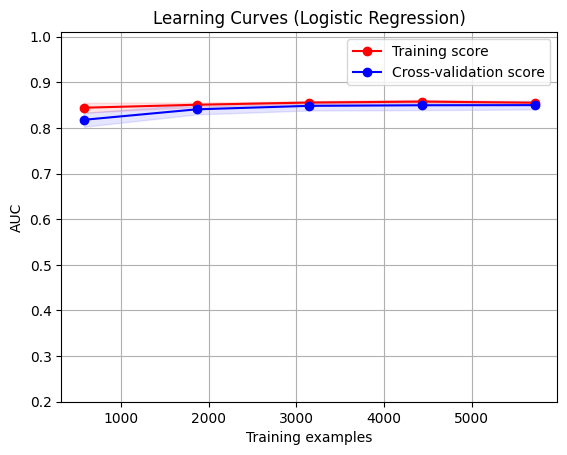

In [116]:

title = "Learning Curves (Logistic Regression)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=12345)
estimator = LogisticRegression( C = 0.0001, penalty = 'l2')
plot_learning_curve(estimator, title, x_train, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()


 C: 1e-05
Train AUC:0.855
Valid AUC:0.857
Train AUC:0.849
Valid AUC:0.845
Train accuracy:0.753
Valid accuracy:0.863
Train recall:0.612
Valid recall:0.617
Train precision:0.854
Valid precision:0.393
Train specificity:0.895
Valid specificity:0.891
Train prevalence:0.500
Valid prevalence:0.102


c:\ProgramData\anaconda3\envs\health\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


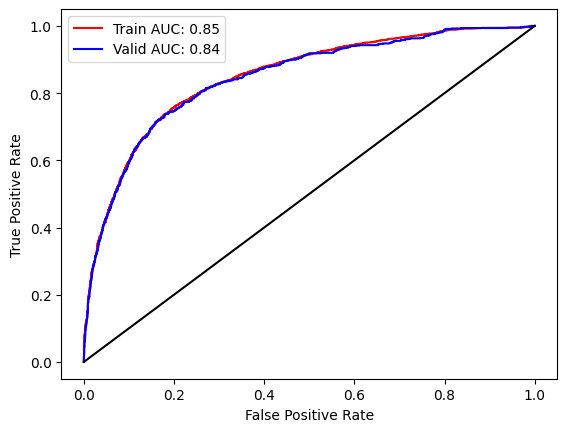


 C: 3e-05
Train AUC:0.855
Valid AUC:0.857
Train AUC:0.853
Valid AUC:0.852
Train accuracy:0.765
Valid accuracy:0.862
Train recall:0.642
Valid recall:0.656
Train precision:0.851
Valid precision:0.394
Train specificity:0.888
Valid specificity:0.885
Train prevalence:0.500
Valid prevalence:0.102


c:\ProgramData\anaconda3\envs\health\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


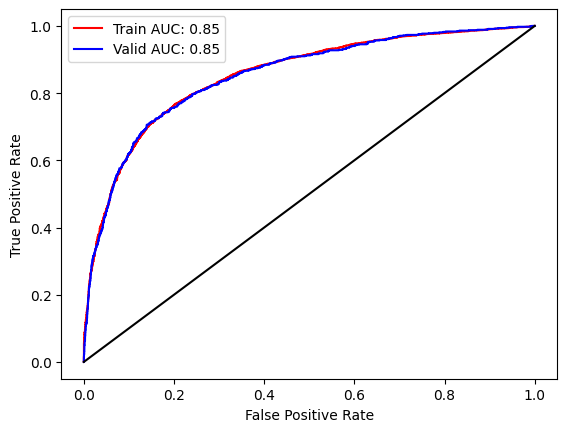


 C: 0.0001
Train AUC:0.855
Valid AUC:0.857
Train AUC:0.855
Valid AUC:0.857
Train accuracy:0.775
Valid accuracy:0.860
Train recall:0.669
Valid recall:0.686
Train precision:0.849
Valid precision:0.394
Train specificity:0.881
Valid specificity:0.880
Train prevalence:0.500
Valid prevalence:0.102


c:\ProgramData\anaconda3\envs\health\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


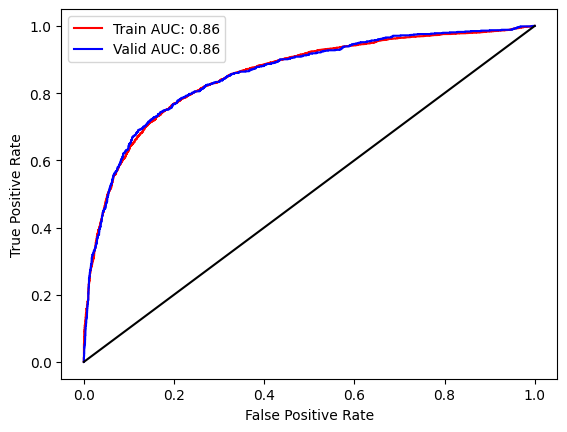


 C: 0.0003
Train AUC:0.855
Valid AUC:0.857
Train AUC:0.856
Valid AUC:0.859
Train accuracy:0.781
Valid accuracy:0.862
Train recall:0.678
Valid recall:0.700
Train precision:0.854
Valid precision:0.399
Train specificity:0.884
Valid specificity:0.880
Train prevalence:0.500
Valid prevalence:0.102


c:\ProgramData\anaconda3\envs\health\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


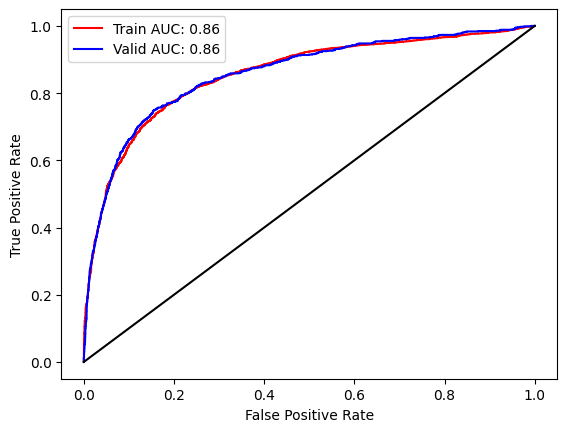


 C: 0.001
Train AUC:0.855
Valid AUC:0.857
Train AUC:0.853
Valid AUC:0.856
Train accuracy:0.775
Valid accuracy:0.847
Train recall:0.681
Valid recall:0.706
Train precision:0.839
Valid precision:0.371
Train specificity:0.870
Valid specificity:0.863
Train prevalence:0.500
Valid prevalence:0.102


c:\ProgramData\anaconda3\envs\health\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


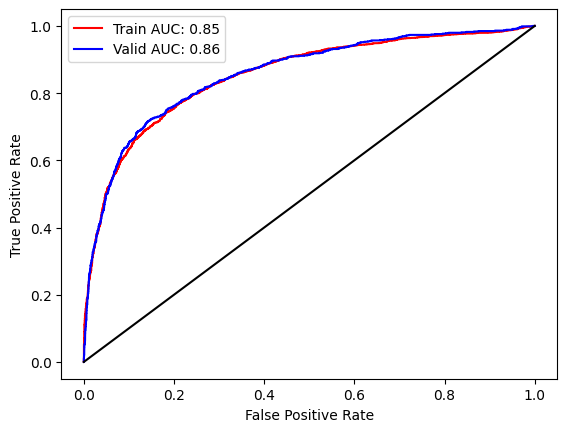


 C: 0.003
Train AUC:0.855
Valid AUC:0.857
Train AUC:0.855
Valid AUC:0.858
Train accuracy:0.779
Valid accuracy:0.857
Train recall:0.683
Valid recall:0.716
Train precision:0.845
Valid precision:0.392
Train specificity:0.874
Valid specificity:0.873
Train prevalence:0.500
Valid prevalence:0.102


c:\ProgramData\anaconda3\envs\health\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


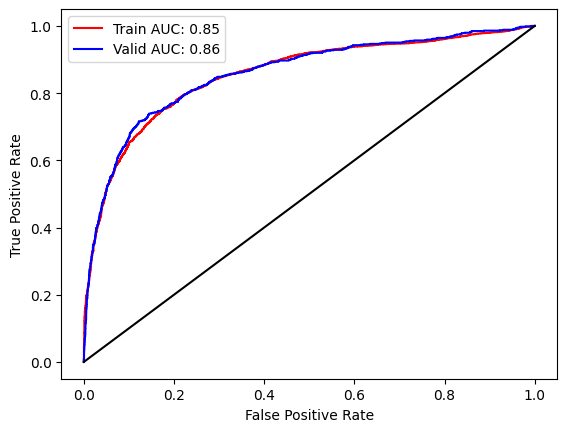

In [117]:
from sklearn.linear_model import LogisticRegression

Cs = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003]
train_aucs = np.zeros(len(Cs))
valid_aucs = np.zeros(len(Cs))

for ii in range(len(Cs)):
    C = Cs[ii]
    print('\n C:', C)

    # logistic regression

    clf=LogisticRegression(C = C, penalty = 'l2', random_state = 12345)
    clf.fit(x_train, y_train)

    model = clf
    y_train_preds = model.predict_proba(x_train)[:,1]
    y_valid_preds = model.predict_proba(x_valid)[:,1]

    auc_train = roc_auc_score(y_train, prdct_train)
    auc_valid = roc_auc_score(y_valid, prdct_valid)
    print('Train AUC:%.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid

    evaluate(prdct_train=y_train_preds, y_train=y_train, prdct_valid=y_valid_preds, y_valid=y_valid)


 classifier:  DecisionTree
Train AUC:0.886
Valid AUC:0.882
Train AUC:0.886
Valid AUC:0.882
Train accuracy:0.819
Valid accuracy:0.845
Train recall:0.776
Valid recall:0.775
Train precision:0.848
Valid precision:0.375
Train specificity:0.861
Valid specificity:0.853
Train prevalence:0.500
Valid prevalence:0.102


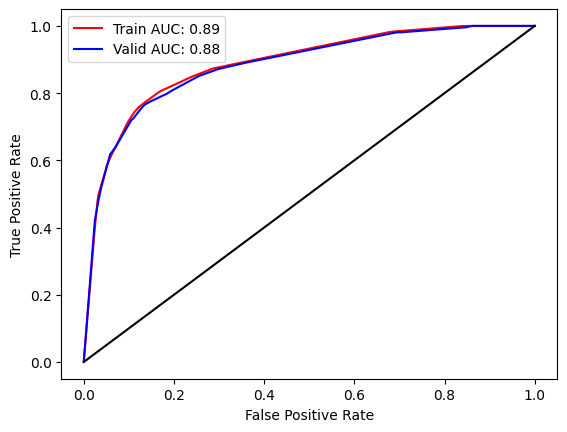


 classifier:  RandomForest
Train AUC:0.903
Valid AUC:0.898
Train AUC:0.903
Valid AUC:0.898
Train accuracy:0.830
Valid accuracy:0.834
Train recall:0.805
Valid recall:0.807
Train precision:0.847
Valid precision:0.361
Train specificity:0.855
Valid specificity:0.838
Train prevalence:0.500
Valid prevalence:0.102


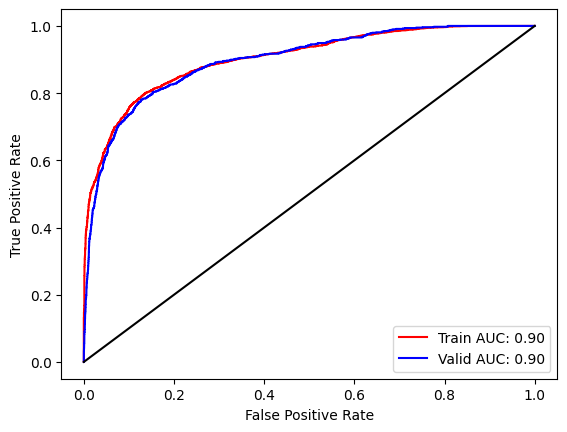


 classifier:  LogisticRegression
Train AUC:0.867
Valid AUC:0.870
Train AUC:0.867
Valid AUC:0.870
Train accuracy:0.789
Valid accuracy:0.828
Train recall:0.741
Valid recall:0.762
Train precision:0.819
Valid precision:0.346
Train specificity:0.837
Valid specificity:0.836
Train prevalence:0.500
Valid prevalence:0.102


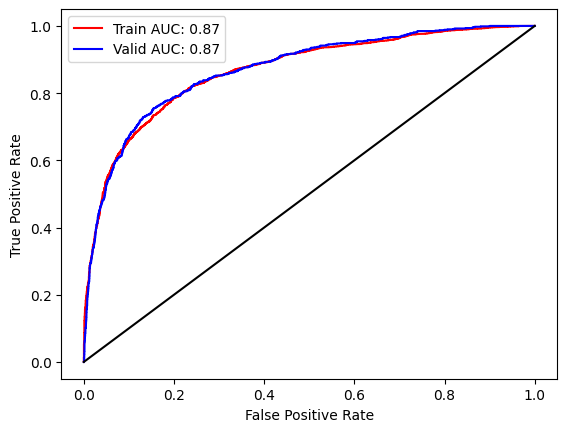


 classifier:  GradientBoosting
Train AUC:0.962
Valid AUC:0.929
Train AUC:0.962
Valid AUC:0.929
Train accuracy:0.894
Valid accuracy:0.856
Train recall:0.863
Valid recall:0.851
Train precision:0.921
Valid precision:0.403
Train specificity:0.926
Valid specificity:0.856
Train prevalence:0.500
Valid prevalence:0.102


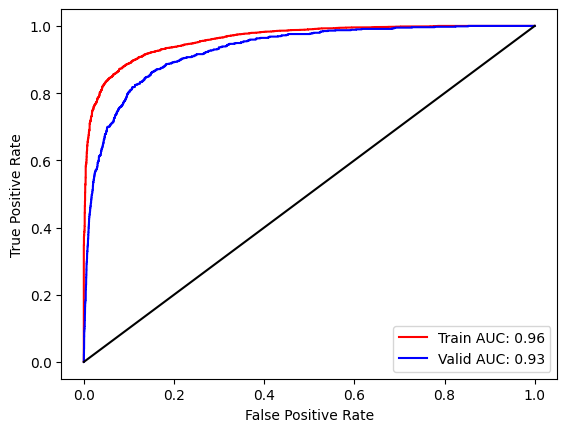


 classifier:  Nearest Neighbors
Train AUC:0.918
Valid AUC:0.868
Train AUC:0.918
Valid AUC:0.868
Train accuracy:0.830
Valid accuracy:0.774
Train recall:0.829
Valid recall:0.816
Train precision:0.830
Valid precision:0.287
Train specificity:0.831
Valid specificity:0.769
Train prevalence:0.500
Valid prevalence:0.102


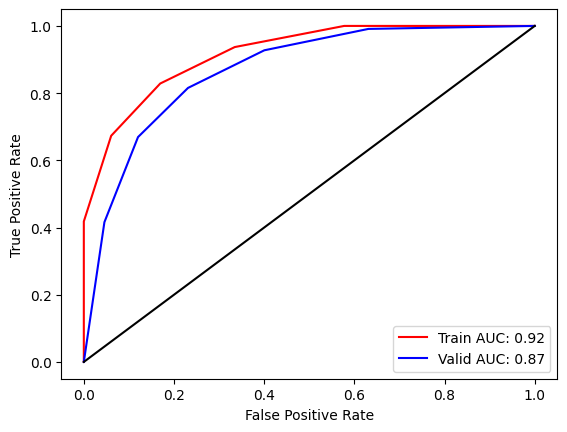


 classifier:  Neural Net
Train AUC:0.885
Valid AUC:0.874
Train AUC:0.885
Valid AUC:0.874
Train accuracy:0.795
Valid accuracy:0.861
Train recall:0.697
Valid recall:0.709
Train precision:0.866
Valid precision:0.398
Train specificity:0.892
Valid specificity:0.878
Train prevalence:0.500
Valid prevalence:0.102


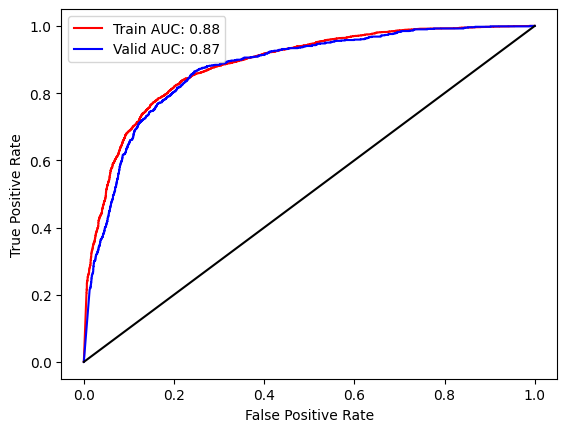


 classifier:  AdaBoost
Train AUC:0.882
Valid AUC:0.886
Train AUC:0.882
Valid AUC:0.886
Train accuracy:0.804
Valid accuracy:0.803
Train recall:0.803
Valid recall:0.808
Train precision:0.804
Valid precision:0.318
Train specificity:0.804
Valid specificity:0.803
Train prevalence:0.500
Valid prevalence:0.102


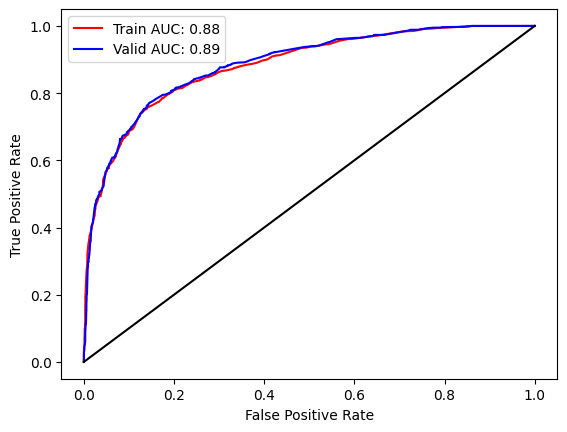


 classifier:  GaussianMB
Train AUC:0.790
Valid AUC:0.792
Train AUC:0.790
Valid AUC:0.792
Train accuracy:0.631
Valid accuracy:0.902
Train recall:0.286
Valid recall:0.308
Train precision:0.921
Valid precision:0.540
Train specificity:0.975
Valid specificity:0.970
Train prevalence:0.500
Valid prevalence:0.102


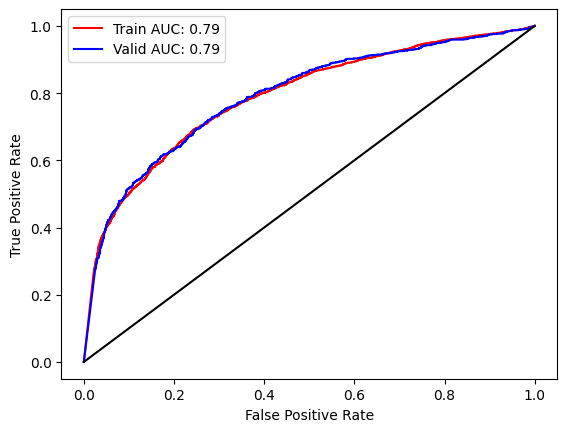


 classifier:  QDA


c:\ProgramData\anaconda3\envs\health\lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Train AUC:0.831
Valid AUC:0.837
Train AUC:0.831
Valid AUC:0.837
Train accuracy:0.619
Valid accuracy:0.906
Train recall:0.253
Valid recall:0.275
Train precision:0.942
Valid precision:0.581
Train specificity:0.984
Valid specificity:0.977
Train prevalence:0.500
Valid prevalence:0.102


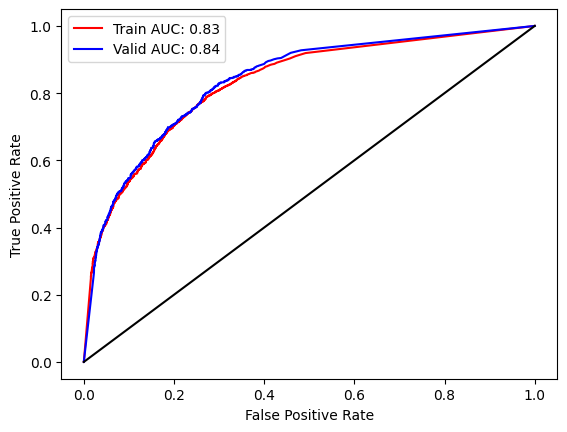

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = {
    'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=12345),
    'RandomForest': RandomForestClassifier(n_estimators=400, max_depth=6,
                                           min_samples_split=2, min_samples_leaf=2,
                                           random_state=12345, n_jobs=-1),
    'LogisticRegression': LogisticRegression(max_iter=1000, n_jobs=-1, random_state=12345),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=400, random_state=12345),
    'Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'Neural Net': MLPClassifier(alpha=1, max_iter=1000, random_state=12345),
    'AdaBoost': AdaBoostClassifier(algorithm="SAMME", random_state=12345),
    'GaussianMB': GaussianNB(),
    'QDA': QuadraticDiscriminantAnalysis()
}

train_aucs = []
valid_aucs = []

for name, clf in classifiers.items():
    print('\n classifier: ', name)
    # logistic regression
    clf.fit(x_train, y_train)

    model = clf
    y_train_preds = model.predict_proba(x_train)[:,1]
    y_valid_preds = model.predict_proba(x_valid)[:,1]

    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    print('Train AUC:%.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)
    train_aucs.append(auc_train)
    valid_aucs.append(auc_valid)

    evaluate(prdct_train=y_train_preds, y_train=y_train, prdct_valid=y_valid_preds, y_valid=y_valid)

                 Name AUC-Train AUC-Validate
0        DecisionTree   0.88611     0.881711
1        RandomForest  0.903066     0.897904
2  LogisticRegression  0.866879     0.870065
3    GradientBoosting  0.961663     0.928645
4   Nearest Neighbors   0.91832     0.868384
5          Neural Net   0.88466     0.873903
6            AdaBoost  0.882253     0.885599
7          GaussianMB   0.78972     0.791607
8                 QDA  0.830822      0.83716


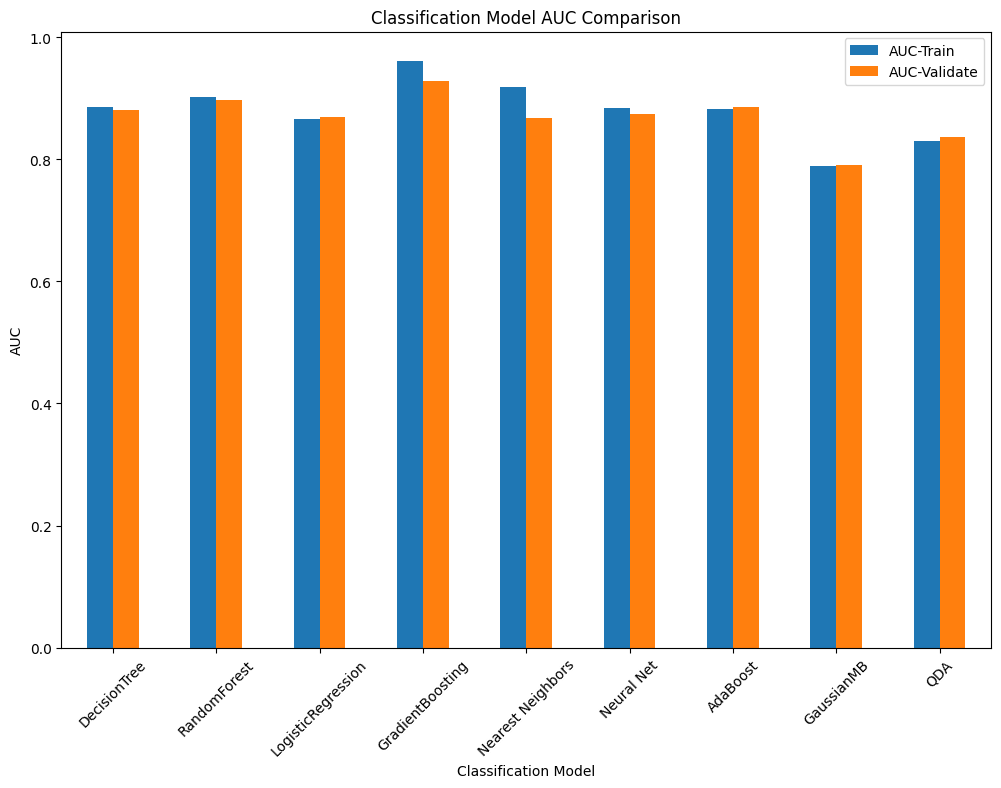

In [ ]:
classifiers_aucs = pd.DataFrame([classifiers.keys(), train_aucs, valid_aucs], 
                                index=['Name', 'AUC-Train', 'AUC-Validate']) 
classifiers_aucs = classifiers_aucs.T
print(classifiers_aucs)

plt.figure(figsize=(12, 8))
classifiers_aucs.plot(kind='bar', ax=plt.gca())
plt.title('Classification Model AUC Comparison')
plt.ylabel('AUC')
plt.xlabel('Classification Model')
#plt.xticks(rotation=45, labels=classifiers_aucs['Name'])
plt.xticks(rotation=45, labels=classifiers_aucs['Name'], ticks=range(0,9))
plt.show()

**Final Model and Evaluation**

In [122]:
clf = GradientBoostingClassifier(n_estimators=400, random_state=12345)
clf.fit(x_train, y_train)

model = clf
y_train_preds = model.predict_proba(x_train)[:,1]
y_valid_preds = model.predict_proba(x_valid)[:,1]
y_test_preds = model.predict_proba(x_test)[:,1]

Train prevalence(n = 7152): 0.500
Valid prevalence(n = 7683): 0.102
Test prevalence(n = 7682): 0.097
Train AUC:0.962
Valid AUC:0.929
Test AUC:0.920
Train accuracy:0.894
Valid accuracy:0.856
Test accuracy:0.851
Train recall:0.863
Valid recall:0.851
Test recall:0.835
Train precision:0.921
Valid precision:0.403
Test precision:0.379
Train specificity:0.926
Valid specificity:0.856
Test specificity:0.853


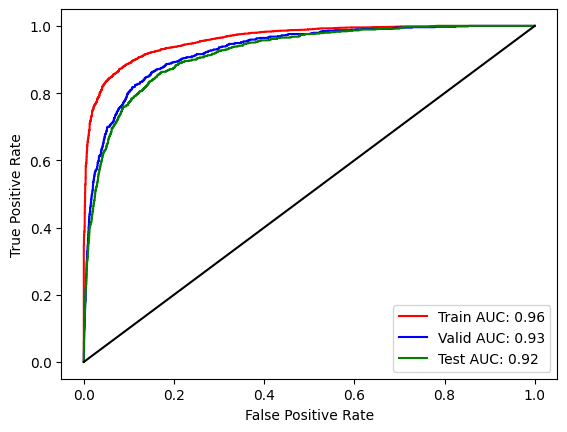

In [123]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)

thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Train prevalence(n = %d): %.3f'%(len(y_train),sum(y_train)/ len(y_train)))
print('Valid prevalence(n = %d): %.3f'%(len(y_valid),sum(y_valid)/ len(y_valid)))
print('Test prevalence(n = %d): %.3f'%(len(y_test),sum(y_test)/ len(y_test)))

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)
print('Test AUC:%.3f'%auc_test)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))
print('Test accuracy:%.3f'%calc_accuracy(y_test, y_test_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))
print('Test recall:%.3f'%calc_recall(y_test, y_test_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))
print('Test precision:%.3f'%calc_precision(y_test, y_test_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))
print('Test specificity:%.3f'%calc_specificity(y_test, y_test_preds, thresh))

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot(fpr_test, tpr_test,'g-',label = 'Test AUC: %.2f'%auc_test)

plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()